# Denoising Diffusion Probabilistic Model

In this project, I explore the implementation and training of diffusion models. Diffusion models are a class of generative models that learn to generate data by simulating a diffusion process, typically from noise to structured data. These models have gained attention for their ability to generate high-quality images and other types of data.

This project aims to implement a diffusion model and train it on the CIFAR-10 dataset. By simulating a diffusion process, the model will learn to generate images of cats resembling those in the CIFAR-10 dataset.

## Setup

In [1]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

The first step is to prepare the data. We will use the CIFAR-10 dataset, which is commonly used for image classification and generation tasks. This dataset consists of 60,000 32x32 color images in 10 classes, with 50,000 training images and 10,000 test images.

We will preprocess the data by normalizing the images to have pixel values between 0 and 1. This normalization is crucial for stable training of the diffusion model. Additionally, we may apply data augmentation techniques such as random cropping, flipping, and rotation to increase the diversity of the training data.

In [3]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels, class_label, transform=None):
        # Filter images for the specified class
        self.idx = np.where(labels == class_label)[0]
        self.images = images[self.idx]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Convert numpy array to PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # image = image.to(torch.float16) # For mixed precision
        return image

# Load CIFAR-10 dataset
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
images, labels = cifar10.data, np.array(cifar10.targets)

# Choose the 'Cat' class, labeled as 3
class_label = 3

# Preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Initialize CustomDataset with the 'Cat' class images
cat_dataset = CustomDataset(images, labels, class_label, transform=preprocess)

# Create DataLoader
train_dataloader = DataLoader(cat_dataset, batch_size=64, shuffle=True)

# print(cat_dataset.images.dtype)
assert len(cat_dataset) == 5000

100%|██████████| 170498071/170498071 [00:03<00:00, 48290102.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Visualize the images after applying the augmentations.

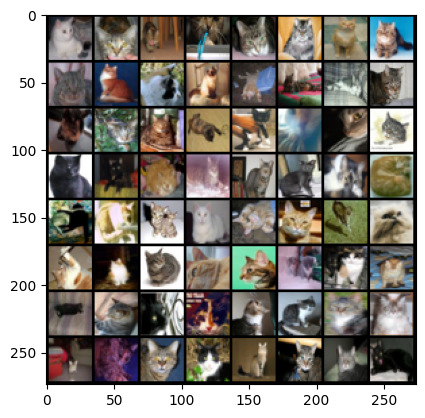

In [4]:
from PIL import Image

def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

# Display the images
images = next(iter(train_dataloader))
grid = show_images(images)
plt.imshow(grid)

cuda:0


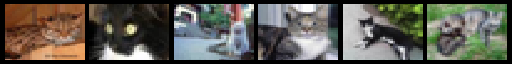

In [5]:
x_test = next(iter(train_dataloader)).to(device)[:6]
print(x_test.device)
show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)

## Forward pass

Here, we implement the forward pass of the diffusion model using the `diffusers` library. The forward process involves gradually adding Gaussian noise to the data over a series of time steps, eventually transforming it into pure noise.

Then, we visualize the target image at different times (every 100 steps) of the forward pass (thus different amounts of noise added).

Device:  cuda
x_test.dtype:  torch.float32
x_test.device:  cuda:0
x_test.shape:  torch.Size([6, 3, 32, 32])


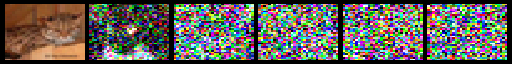

In [6]:
from diffusers import DDPMScheduler

print("Device: ", device)
print("x_test.dtype: ", x_test.dtype)
print("x_test.device: ", x_test.device)
print("x_test.shape: ", x_test.shape)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
timesteps = torch.linspace(0, 999, 6).long().to(device)
noise = torch.randn_like(x_test).to(device)
noisy_xtest = noise_scheduler.add_noise(x_test, noise, timesteps)
show_images(noisy_xtest).resize((8 * 64, 64), resample=Image.NEAREST)

### Reverse pass - denoising

In the reverse pass, we train a neural network to denoise the diffusion process. The idea is that the neural network learns to "create" images out of pure noise by learning to denoise the noisy data step-by-step until it generates realistic images. The neural network used here is a modified UNet2DModel. The modification was to remove the last layers of both the up and down blocks because they were causing issues with memory format.

Note that the following tutorials from HuggingFace were referenced in writing the code for this section:

1. https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb

2. https://huggingface.co/docs/diffusers/en/tutorials/basic_training#training-configuration

In [9]:
from diffusers import UNet2DModel
from dataclasses import dataclass

# Define configuration
@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    batch_size = 64
    num_epochs = 100 # 50
    learning_rate = 4e-4
    lr_warmup_steps = 500

    # train_batch_size = 64
    # eval_batch_size = 64  # how many images to sample during evaluation
    # output_dir = "ddpm-cats-32"
    # gradient_accumulation_steps = 1
    # save_image_epochs = 10
    # save_model_epochs = 30
    # mixed_precision = "no" # "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    # overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    # seed = 42

config = TrainingConfig()

# Initialize the UNet2DModel
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

print("Model initialized to device: ", device)
print("len(train_dataloader): ", len(train_dataloader))
print("model.block_out_channels: ", model.block_out_channels)

Model initialized to device:  cuda
len(train_dataloader):  79
model.block_out_channels:  (64, 128, 128, 256)


<ipython-input-9-f3e932897c08>:49: FutureWarning: Accessing config attribute `block_out_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'block_out_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.block_out_channels'.
  print("model.block_out_channels: ", model.block_out_channels)


## Train

We will train the diffusion model using a combination of the forward and reverse processes. The training process will involve the following steps:
1. **Forward Process:** Add Gaussian noise to the images from the CIFAR-10 dataset over a series of time steps.
2. **Reverse Process:** Train the denoising network to reverse the added noise step-by-step, starting from the noisy images and aiming to reconstruct the original images.

### Loss Function
The loss function for training the diffusion model typically involves minimizing the difference between the denoised images and the original images at each time step. This encourages the model to accurately reverse the noise addition process.

### Optimization
We will use the Adam optimizer to train the denoising network. The training process will be monitored to ensure that the model converges to a state where it can effectively generate realistic images from noise.

Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:5, loss: 0.07631151628079294


Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:10, loss: 0.06888771241035642


Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:15, loss: 0.0680971835044366


Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:20, loss: 0.06596188468835022


Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:25, loss: 0.06189204361053962


Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:30, loss: 0.06293563346696805


Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:35, loss: 0.05855776836411863


Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:40, loss: 0.062107500914908666


Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:45, loss: 0.06063369642707366


Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:50, loss: 0.060439141255013554


Epoch 51:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:55, loss: 0.06145616351992269


Epoch 56:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:60, loss: 0.05853584880315805


Epoch 61:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:65, loss: 0.058841837735115726


Epoch 66:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:70, loss: 0.06194716102526158


Epoch 71:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:75, loss: 0.05903954058885574


Epoch 76:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:80, loss: 0.0596712514097932


Epoch 81:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:85, loss: 0.059043397820448575


Epoch 86:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:90, loss: 0.05888165976805023


Epoch 91:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:95, loss: 0.0569455371815947


Epoch 96:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:100, loss: 0.061357455068751225
Training completed.
Saving model.
Plotting...


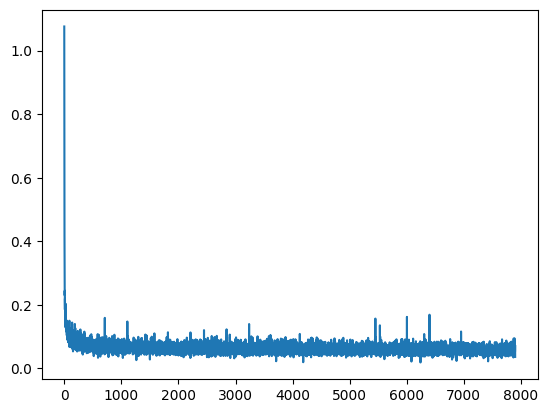

In [10]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
from diffusers import DDPMScheduler
import gc

gc.collect()
torch.cuda.empty_cache()

def train_loop_simple(config, model, noise_scheduler, optimizer, train_dataloader, device):
    model.to(device)
    model.train()

    losses = []

    for epoch in range(config.num_epochs):
        # Wrap train_dataloader with tqdm for progress visualization
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

        for step, batch in enumerate(progress_bar):
            clean_images = batch.to(device)
            # Sample noise to add to the images
            noise = torch.randn_like(clean_images)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bs,), device=device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Get the model prediction
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            # Calculate the loss
            # loss = F.mse_loss(noise_pred, noise)
            loss = F.mse_loss(noise_pred.contiguous(), noise.contiguous())
            optimizer.zero_grad()  # Zero the gradients before backward pass
            loss.backward()
            losses.append(loss.item())

            # Update the model parameters with the optimizer
            optimizer.step()

            # Optionally, update the progress bar with the current loss
            progress_bar.set_postfix(loss=loss.item())

        if (epoch + 1) % 5 == 0:
            loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
            print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

    print("Training completed.")
    return model, losses

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, training_losses = train_loop_simple(config, model, noise_scheduler, optimizer, train_dataloader, device)

print("Saving model.")
torch.save(model.state_dict(), "./diffusion_model")

print("Plotting...")

plt.plot(training_losses)

## Results and Observations

After training the diffusion model, we will evaluate its performance by generating images from random noise and comparing them to the images in the CIFAR-10 dataset.

We visually analyze the quality of the generated images by showing intermediate steps from noise to final generated images.

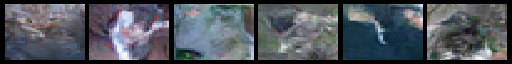

In [11]:
# Denoise manually

# Note that here I'm using a different noise scheduler so that
# I can denoise for an arbitrary number of steps
steps = 5000
noise_scheduler2 = DDPMScheduler(num_train_timesteps=steps) #, beta_schedule="squaredcos_cap_v2")

sample = torch.randn(6, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler2.timesteps):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler2.step(residual, t, sample).prev_sample

show_images(sample).resize((8 * 64, 64), resample=Image.NEAREST)

  0%|          | 0/1000 [00:00<?, ?it/s]

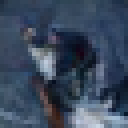

In [12]:
# Visualize output with DDPMPipeline

from diffusers import DDPMPipeline

# Note that here we don't begin with a sample set by us

# Denoise with DDPMPipeline
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler2)
pipeline_output = image_pipe()
pipeline_output.images[0].resize((128, 128), resample=Image.NEAREST)